In [2]:
import pandas as pd
import glob
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import metapredict as meta
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings('ignore')
sns.set_context('talk')
import pandas.io.common

# 0. Downloading MTR scores for all positions of TF cds

In [7]:
cds_mtr = []

cds_paths = glob.glob("../soto_analysis/outputs/mutations/cds_mtr_to_positions/*")

for path in cds_paths:
    ENST = path.split("/")[-1].split(".bed")[0]
   # if ENST in set(ad_mtr["ENST"]):
    try:
        df = pd.read_csv(path, sep = "\t", header = None)
        cds_mtr.append(df)
    except pandas.errors.EmptyDataError:
        print(ENST, " is empty and has been skipped.")

cds_mtr = pd.concat(cds_mtr)
cds_mtr = cds_mtr.rename(columns = {3: "ENST", 8: "MTR"})
cds_mtr

ENST00000422806  is empty and has been skipped.
ENST00000425953  is empty and has been skipped.
ENST00000468660  is empty and has been skipped.
ENST00000379044  is empty and has been skipped.
ENST00000376983  is empty and has been skipped.
ENST00000338637  is empty and has been skipped.
ENST00000400120  is empty and has been skipped.
ENST00000540921  is empty and has been skipped.
ENST00000376207  is empty and has been skipped.
ENST00000283891  is empty and has been skipped.
ENST00000321217  is empty and has been skipped.
ENST00000534327  is empty and has been skipped.
ENST00000326624  is empty and has been skipped.
ENST00000383070  is empty and has been skipped.
ENST00000339249  is empty and has been skipped.
ENST00000370766  is empty and has been skipped.
ENST00000310125  is empty and has been skipped.
ENST00000373125  is empty and has been skipped.
ENST00000315869  is empty and has been skipped.
ENST00000376670  is empty and has been skipped.
ENST00000374259  is empty and has been s

,0,1,2,ENST,4,5,6,7,MTR,9,10
0,2,27149136,27149137,ENST00000296096,1,2,27149136,27149137,0.963783,S,2
1,2,27149137,27149138,ENST00000296096,1,2,27149137,27149138,0.963783,S,2
2,2,27149139,27149140,ENST00000296096,1,2,27149139,27149140,0.938410,Q,3
3,2,27149140,27149141,ENST00000296096,1,2,27149140,27149141,0.938410,Q,3
4,2,27149141,27149142,ENST00000296096,1,2,27149141,27149142,0.938410,Q,3
...,...,...,...,...,...,...,...,...,...,...,...
3131,16,49730859,49730860,ENST00000561648,-1,16,49730859,49730860,0.971544,D,63
3132,16,49730860,49730861,ENST00000561648,-1,16,49730860,49730861,0.971544,D,63
3133,16,49730861,49730862,ENST00000561648,-1,16,49730861,49730862,0.937262,E,62
3134,16,49730862,49730863,ENST00000561648,-1,16,49730862,49730863,0.937262,E,62


In [9]:
len(set(cds_mtr["ENST"]))

1497

# 1. Constraint of activator TFs vs other TFs?

In [48]:
lambert_TF_ENSTs = pd.read_csv("../output/TFs_with_ENST.csv", index_col = 0)

uniprotID_ENST_mapping_dict = dict(zip(lambert_TF_ENSTs["canonical_uniprot_id_isoform"],
                                       lambert_TF_ENSTs["ENST"]))

uniprotID_isoform_mapping_dict = dict(zip(lambert_TF_ENSTs["uniprotID"],
                                       lambert_TF_ENSTs["canonical_uniprot_id_isoform"]))
#uniprotID_ENST_mapping_dict
lambert_TF_ENSTs["ENST"] = lambert_TF_ENSTs["ENST"].str.split(".").str[0]
lambert_TF_ENSTs

,uniprotID,ENST,canonical_uniprot_id_isoform
0,A0A087WUV0,ENST00000425953,A0A087WUV0
1,A0AVK6,ENST00000250024,A0AVK6
2,A1YPR0,ENST00000535628,A1YPR0
3,A2RRD8,ENST00000391781,A2RRD8
4,A2RU54,ENST00000339992,A2RU54
...,...,...,...
2127,Q9Y692,ENST00000294409,Q9Y692-1
2128,Q9Y6Q3,ENST00000374227,Q9Y6Q3-1
2129,Q9Y6Q9,ENST00000371998,Q9Y6Q9-1
2130,Q9Y6X0,ENST00000649279,Q9Y6X0-1


In [50]:
RDs = pd.read_csv("../data/tycko_soto_delrosso_RD_coordinate_data_updated_12-2-24.csv", header = None)
RDs = RDs.rename(columns = {0: "uniprotID"})
RDs = pd.merge(RDs, lambert_TF_ENSTs)
RDs

,uniprotID,1,ENST,canonical_uniprot_id_isoform
0,A0AVK6,"[(532, 611)]",ENST00000250024,A0AVK6
1,A0PJY2,"[(2, 101), (308, 387)]",ENST00000442488,A0PJY2-1
2,A1A519,"[(35, 114)]",ENST00000695508,A1A519-1
3,A1YPR0,"[(1, 132), (192, 431)]",ENST00000535628,A1YPR0
4,A2RRD8,"[(1, 100)]",ENST00000391781,A2RRD8
...,...,...,...,...
1021,Q9Y692,"[(52, 141), (202, 291)]",ENST00000294409,Q9Y692-1
1022,Q9Y6Q9,"[(12, 181), (292, 371), (652, 861)]",ENST00000371998,Q9Y6Q9-1
1023,Q9Y6X0,"[(362, 441), (1002, 1121)]",ENST00000649279,Q9Y6X0-1
1024,Q9Y6X8,"[(2, 81), (263, 446)]",ENST00000314393,Q9Y6X8


In [12]:
activator_TFs_tbl = pd.read_csv("../soto_analysis/outputs/all_TFs_table_proteins.txt", sep = "\t", index_col = 0)
activator_TFs_tbl

,1,2,uniprotID,ENSG,ENST,DBD_coords,AD_coords,RD_coords,Bif_coords,length
Unnamed: 0,,,,,,,,,,
0,NaN,NaN,A6NJG6,NaN,ENST00000334384,79-135,142-315,152-315,NaN,1
1,NaN,NaN,A8MTJ6,NaN,ENST00000428390,145-234,369-420,NaN,NaN,1
2,NaN,NaN,A8MYZ6,NaN,ENST00000641094,89-178,382-491,NaN,NaN,1
3,NaN,NaN,A8MZ59,NaN,ENST00000640845,31-65,92-181,22-101,NaN,1
4,NaN,NaN,O00321,NaN,ENST00000403402,242-321,1-162,22-121,NaN,1
...,...,...,...,...,...,...,...,...,...,...
441,NaN,NaN,Q9Y5R6,NaN,ENST00000382276,72-118,172-251,182-261,NaN,1
442,NaN,NaN,Q9Y5W3,NaN,ENST00000248071,"272-296,302-326,332-354",1-89,62-268,NaN,1
443,NaN,NaN,Q9Y692,NaN,ENST00000294409,89-165,422-573,"52-141,202-291",NaN,1


## Activator vs non-activators

In [21]:
activator_cds_mtr = cds_mtr[cds_mtr["ENST"].isin(activator_TFs_tbl["ENST"])]
non_activator_cds_mtr = cds_mtr[~cds_mtr["ENST"].isin(activator_TFs_tbl["ENST"])]

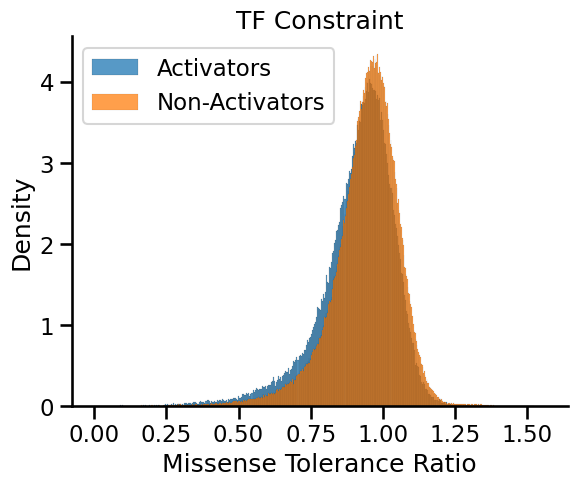

In [20]:
sns.histplot(activator_cds_mtr["MTR"], stat = "density", label = "Activators")
sns.histplot(non_activator_cds_mtr["MTR"], stat = "density", label = "Non-Activators")
plt.legend()
plt.title("TF Constraint")
plt.xlabel("Missense Tolerance Ratio")
sns.despine()

## Activators vs bifunc vs non-activators

In [51]:
only_activator_rows = activator_TFs_tbl[activator_TFs_tbl["RD_coords"].isna()]
only_activator_mtr = cds_mtr[cds_mtr["ENST"].isin(only_activator_rows["ENST"])]

bifunc_rows = activator_TFs_tbl.dropna(subset = ["RD_coords"])
bifunc_mtr = cds_mtr[cds_mtr["ENST"].isin(bifunc_rows["ENST"])]

only_repressor_mtr = cds_mtr[cds_mtr["ENST"].isin(RDs["ENST"])]

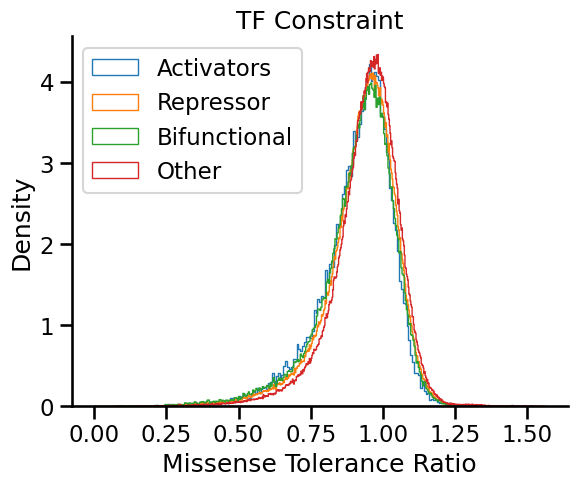

In [66]:
sns.histplot(only_activator_mtr["MTR"] , label = "Activators", stat = "density", element = "step", lw = 1, alpha = 0)
sns.histplot(only_repressor_mtr["MTR"] , label = "Repressor" , stat = "density", element = "step", lw = 1, alpha = 0)
sns.histplot(bifunc_mtr["MTR"] , label = "Bifunctional" , stat = "density", element = "step", lw = 1, alpha = 0)
sns.histplot(non_activator_cds_mtr["MTR"] , label = "Other" , stat = "density", element = "step", lw = 1, alpha = 0)

#sns.kdeplot(bifunc_mtr["MTR"] , label = "Bifunctional" )
#sns.kdeplot(non_activator_cds_mtr["MTR"] , label = "Other" )

#sns.histplot(non_activator_cds_mtr["MTR"], stat = "density", label = "Non-Activators", alpha = 0.5)
plt.legend()
plt.title("TF Constraint")
plt.xlabel("Missense Tolerance Ratio")
sns.despine()

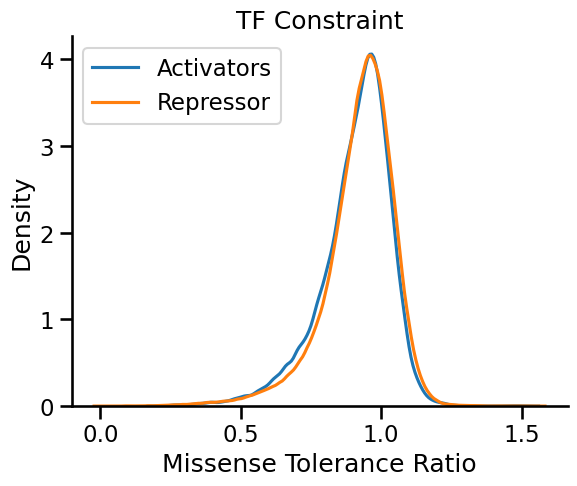

In [57]:
sns.kdeplot(only_activator_mtr["MTR"] , label = "Activators" )
sns.kdeplot(only_repressor_mtr["MTR"] , label = "Repressor" )
#sns.kdeplot(bifunc_mtr["MTR"] , label = "Bifunctional" )
#sns.kdeplot(non_activator_cds_mtr["MTR"] , label = "Other" )

#sns.histplot(non_activator_cds_mtr["MTR"], stat = "density", label = "Non-Activators", alpha = 0.5)
plt.legend()
plt.title("TF Constraint")
plt.xlabel("Missense Tolerance Ratio")
sns.despine()

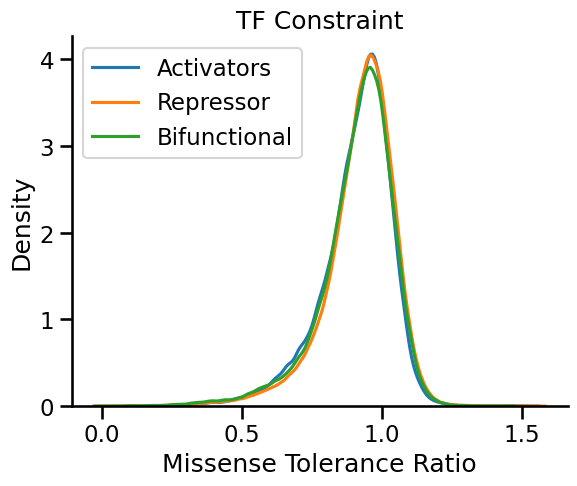

In [58]:
sns.kdeplot(only_activator_mtr["MTR"] , label = "Activators" )
sns.kdeplot(only_repressor_mtr["MTR"] , label = "Repressor" )
sns.kdeplot(bifunc_mtr["MTR"] , label = "Bifunctional" )
#sns.kdeplot(non_activator_cds_mtr["MTR"] , label = "Other" )

#sns.histplot(non_activator_cds_mtr["MTR"], stat = "density", label = "Non-Activators", alpha = 0.5)
plt.legend()
plt.title("TF Constraint")
plt.xlabel("Missense Tolerance Ratio")
sns.despine()

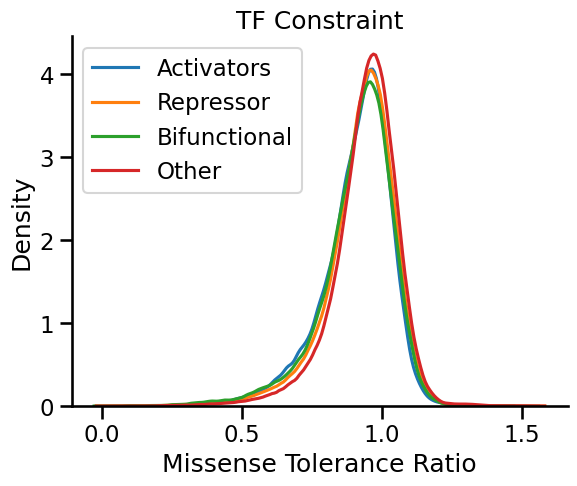

In [59]:
sns.kdeplot(only_activator_mtr["MTR"] , label = "Activators" )
sns.kdeplot(only_repressor_mtr["MTR"] , label = "Repressor" )
sns.kdeplot(bifunc_mtr["MTR"] , label = "Bifunctional" )
sns.kdeplot(non_activator_cds_mtr["MTR"] , label = "Other" )

#sns.histplot(non_activator_cds_mtr["MTR"], stat = "density", label = "Non-Activators", alpha = 0.5)
plt.legend()
plt.title("TF Constraint")
plt.xlabel("Missense Tolerance Ratio")
sns.despine()

# 2. Ordered RDs vs other RDs

In [68]:
! pwd

/Users/sanjanakotha/Desktop/Staller_Lab/SFARI/notebooks


In [106]:
RD_seqs = pd.read_csv("../data/full_tycko_soto_delrosso_rd_list.csv", header = None)
RD_seqs = RD_seqs.rename(columns = {0: "uniprotID", 3 : "sequence", 4: "annot_start", 5: "annot_end"})
RD_seqs = pd.merge(RD_seqs, lambert_TF_ENSTs, on = "uniprotID")
RD_seqs

,uniprotID,1,2,sequence,annot_start,annot_end,6,7,8,9,ENST,canonical_uniprot_id_isoform
0,A0AVK6,delrosso,NaN,QSVTPPQGLSPTVCTTHSSKATGSKDSTDATTEKAANDTSKASAST...,532,611,A0AVK6,A0AVK6,532.0,611.0,ENST00000250024,A0AVK6
1,A0PJY2,delrosso,NaN,DSSCHNATTKMLATAPARGNMMSTSKPLAFSIERIMARTPEPKALP...,2,101,"A0PJY2, A0PJY2-2, A0PJY2-3","A0PJY2, A0PJY2-2, A0PJY2-3",2.0,101.0,ENST00000442488,A0PJY2-1
2,A0PJY2,delrosso,NaN,QEKPHKCNQCGKAFNRSSTLNTHTRIHAGYKPFVCEFCGKGFHQKG...,308,387,"A0PJY2, A0PJY2-2, A0PJY2-3","A0PJY2, A0PJY2-2, A0PJY2-3",308.0,387.0,ENST00000442488,A0PJY2-1
3,A1A519,delrosso,NaN,PQSPLAQVQERGETPPRSQHVSLSSYSSYKTCVSSLCVNKEERGMK...,35,114,"A1A519, A1A519-2, A1A519-3, A1A519-4","A1A519, A1A519-2, A1A519-3, A1A519-4",35.0,114.0,ENST00000695508,A1A519-1
4,A1YPR0,tyckosoto,True,MANDIDELIGIPFPNHSSEVLCSLNEQRHDGLLCDVLLVVQEQEYR...,1,132,A1YPR0,A1YPR0,1.0,132.0,ENST00000535628,A1YPR0
...,...,...,...,...,...,...,...,...,...,...,...,...
1727,Q9UPW6,delrosso,NaN,IRNQVPALQPIMSPGLLSPQLSPQLVRQQIAMAHLINQQIAVSRLL...,164,311,"Q9UPW6, Q9UPW6-2",NaN,NaN,NaN,ENST00000260926,Q9UPW6-1
1728,Q9Y2K7,"delrosso, tyckosoto",NaN,VPTIPITKPHTMKPAPRLTPVRPAAASPIVSGARRRRVRCRKCKAC...,93,352,"Q9Y2K7, Q9Y2K7-2, Q9Y2K7-3, Q9Y2K7-4, Q9Y2K7-5",NaN,NaN,NaN,ENST00000529006,Q9Y2K7-1
1729,Q9Y458,"delrosso, tyckosoto",NaN,MALSSRARAFSVEALVGRPSKRKLQDPIQAEQPELREKKGGEEEEE...,1,301,"Q9Y458, Q9Y458-2",NaN,NaN,NaN,ENST00000373294,Q9Y458-1
1730,Q9Y483,delrosso,NaN,VIDSDEKWLCRQCVFATTTKRGGALKKGPNAKALQVMKQTLPYSVA...,142,279,"Q9Y483, Q9Y483-3, Q9Y483-4",NaN,NaN,NaN,ENST00000370298,Q9Y483-1


In [107]:
# Adding percent disorder
percent_disorders = []
for i in RD_seqs.index:
    seq = RD_seqs["sequence"].iloc[i]
    percent_disorders.append(meta.percent_disorder(seq))

RD_seqs["percent_disorder"] = percent_disorders
RD_seqs

,uniprotID,1,2,sequence,annot_start,annot_end,6,7,8,9,ENST,canonical_uniprot_id_isoform,percent_disorder
0,A0AVK6,delrosso,NaN,QSVTPPQGLSPTVCTTHSSKATGSKDSTDATTEKAANDTSKASAST...,532,611,A0AVK6,A0AVK6,532.0,611.0,ENST00000250024,A0AVK6,100.000
1,A0PJY2,delrosso,NaN,DSSCHNATTKMLATAPARGNMMSTSKPLAFSIERIMARTPEPKALP...,2,101,"A0PJY2, A0PJY2-2, A0PJY2-3","A0PJY2, A0PJY2-2, A0PJY2-3",2.0,101.0,ENST00000442488,A0PJY2-1,100.000
2,A0PJY2,delrosso,NaN,QEKPHKCNQCGKAFNRSSTLNTHTRIHAGYKPFVCEFCGKGFHQKG...,308,387,"A0PJY2, A0PJY2-2, A0PJY2-3","A0PJY2, A0PJY2-2, A0PJY2-3",308.0,387.0,ENST00000442488,A0PJY2-1,6.250
3,A1A519,delrosso,NaN,PQSPLAQVQERGETPPRSQHVSLSSYSSYKTCVSSLCVNKEERGMK...,35,114,"A1A519, A1A519-2, A1A519-3, A1A519-4","A1A519, A1A519-2, A1A519-3, A1A519-4",35.0,114.0,ENST00000695508,A1A519-1,48.750
4,A1YPR0,tyckosoto,True,MANDIDELIGIPFPNHSSEVLCSLNEQRHDGLLCDVLLVVQEQEYR...,1,132,A1YPR0,A1YPR0,1.0,132.0,ENST00000535628,A1YPR0,5.303
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,Q9UPW6,delrosso,NaN,IRNQVPALQPIMSPGLLSPQLSPQLVRQQIAMAHLINQQIAVSRLL...,164,311,"Q9UPW6, Q9UPW6-2",NaN,NaN,NaN,ENST00000260926,Q9UPW6-1,78.378
1728,Q9Y2K7,"delrosso, tyckosoto",NaN,VPTIPITKPHTMKPAPRLTPVRPAAASPIVSGARRRRVRCRKCKAC...,93,352,"Q9Y2K7, Q9Y2K7-2, Q9Y2K7-3, Q9Y2K7-4, Q9Y2K7-5",NaN,NaN,NaN,ENST00000529006,Q9Y2K7-1,21.154
1729,Q9Y458,"delrosso, tyckosoto",NaN,MALSSRARAFSVEALVGRPSKRKLQDPIQAEQPELREKKGGEEEEE...,1,301,"Q9Y458, Q9Y458-2",NaN,NaN,NaN,ENST00000373294,Q9Y458-1,30.897
1730,Q9Y483,delrosso,NaN,VIDSDEKWLCRQCVFATTTKRGGALKKGPNAKALQVMKQTLPYSVA...,142,279,"Q9Y483, Q9Y483-3, Q9Y483-4",NaN,NaN,NaN,ENST00000370298,Q9Y483-1,2.899


<Axes: xlabel='percent_disorder', ylabel='Count'>

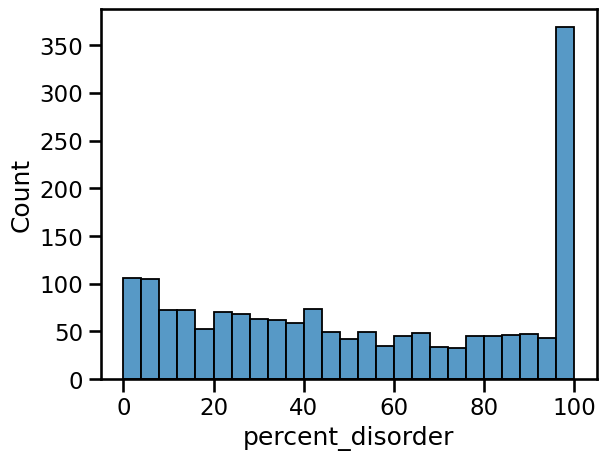

In [108]:
sns.histplot(RD_seqs["percent_disorder"], bins = 25)

In [110]:
RD_seqs = RD_seqs[["uniprotID", "annot_start", "annot_end", "ENST", "percent_disorder"]]
RD_seqs

,uniprotID,annot_start,annot_end,ENST,percent_disorder
0,A0AVK6,532,611,ENST00000250024,100.000
1,A0PJY2,2,101,ENST00000442488,100.000
2,A0PJY2,308,387,ENST00000442488,6.250
3,A1A519,35,114,ENST00000695508,48.750
4,A1YPR0,1,132,ENST00000535628,5.303
...,...,...,...,...,...
1727,Q9UPW6,164,311,ENST00000260926,78.378
1728,Q9Y2K7,93,352,ENST00000529006,21.154
1729,Q9Y458,1,301,ENST00000373294,30.897
1730,Q9Y483,142,279,ENST00000370298,2.899


In [207]:
RD_with_mtr = pd.merge(RD_seqs, cds_mtr, on = "ENST")
RD_with_mtr = RD_with_mtr.rename(columns = {10 : "prot_pos"})
RD_with_mtr = RD_with_mtr[(RD_with_mtr["annot_start"] < RD_with_mtr["prot_pos"]) & (RD_with_mtr["annot_end"] > RD_with_mtr["prot_pos"])]
RD_with_mtr = RD_with_mtr.drop_duplicates()
RD_with_mtr

,uniprotID,annot_start,annot_end,ENST,percent_disorder,0,1,2,4,5,6,7,MTR,9,prot_pos
615,A0AVK6,532,611,ENST00000250024,100.000,11,19229517,19229518,-1,11,19229517,19229518,0.965695,L,610
616,A0AVK6,532,611,ENST00000250024,100.000,11,19229518,19229519,-1,11,19229518,19229519,0.965695,L,610
617,A0AVK6,532,611,ENST00000250024,100.000,11,19229519,19229520,-1,11,19229519,19229520,0.960322,M,609
618,A0AVK6,532,611,ENST00000250024,100.000,11,19229520,19229521,-1,11,19229520,19229521,0.960322,M,609
619,A0AVK6,532,611,ENST00000250024,100.000,11,19229521,19229522,-1,11,19229521,19229522,0.960322,M,609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225814,Q9Y6Y1,912,1051,ENST00000303635,28.571,1,7736421,7736422,1,1,7736421,7736422,0.936731,A,1049
3225815,Q9Y6Y1,912,1051,ENST00000303635,28.571,1,7736422,7736423,1,1,7736422,7736423,0.936731,A,1049
3225816,Q9Y6Y1,912,1051,ENST00000303635,28.571,1,7736424,7736425,1,1,7736424,7736425,0.936310,C,1050
3225817,Q9Y6Y1,912,1051,ENST00000303635,28.571,1,7736425,7736426,1,1,7736425,7736426,0.936310,C,1050


In [208]:
disordered_RD_mtr = RD_with_mtr[RD_with_mtr["percent_disorder"] > 70]
ordered_RD_mtr = RD_with_mtr[RD_with_mtr["percent_disorder"] <= 70]

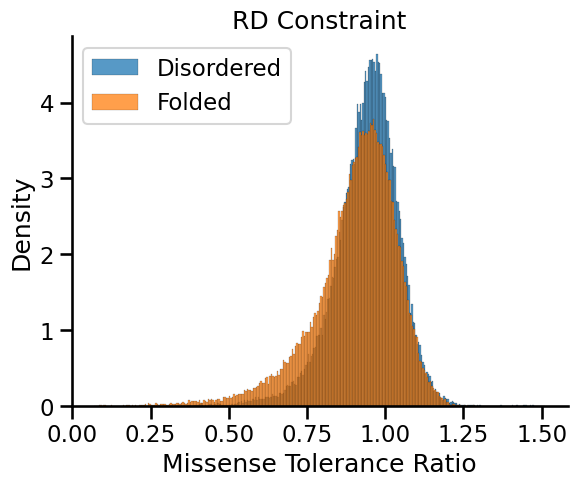

In [209]:
sns.histplot(disordered_RD_mtr["MTR"], stat = "density", label = "Disordered")
sns.histplot(ordered_RD_mtr["MTR"], stat = "density", label = "Folded")
plt.legend(loc = "upper left")
plt.title("RD Constraint")
plt.xlabel("Missense Tolerance Ratio")
sns.despine()

In [210]:
domain_mtr = []

ENSTs = glob.glob("../soto_analysis/outputs/mutations/domains_mtr/*")

for ENST in ENSTs:
    try:
        df = pd.read_csv(ENST, sep = "\t", header = None)
        domain_mtr.append(df)
    except pandas.errors.EmptyDataError:
        print(ENST, " is empty and has been skipped.")

domain_mtr = pd.concat(domain_mtr)
domain_mtr

../soto_analysis/outputs/mutations/domains_mtr/ENST00000468660.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000379044.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000376983.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000315869.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000376670.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000374259.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000528386.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000373294.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000373514.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000308167.bed  is empty and has been skipped.
../soto_an

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,6,53130871,53130872,DBD,NaN,.,-,ENST00000259803,6,53130871,53130872,ENST00000259803,-1,6,53130871,53130872,0.654677
1,6,53130872,53130873,DBD,NaN,.,-,ENST00000259803,6,53130872,53130873,ENST00000259803,-1,6,53130872,53130873,0.654677
2,6,53130873,53130874,DBD,NaN,.,-,ENST00000259803,6,53130873,53130874,ENST00000259803,-1,6,53130873,53130874,0.654677
3,6,53130874,53130875,DBD,NaN,.,-,ENST00000259803,6,53130874,53130875,ENST00000259803,-1,6,53130874,53130875,0.719452
4,6,53130875,53130876,DBD,NaN,.,-,ENST00000259803,6,53130875,53130876,ENST00000259803,-1,6,53130875,53130876,0.719452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,19,15379723,15379724,AD,NaN,.,-,ENST00000269701,19,15379723,15379724,ENST00000269701,-1,19,15379723,15379724,0.946138
1902,19,15379724,15379725,AD,NaN,.,-,ENST00000269701,19,15379724,15379725,ENST00000269701,-1,19,15379724,15379725,0.946138
1903,19,15379725,15379726,AD,NaN,.,-,ENST00000269701,19,15379725,15379726,ENST00000269701,-1,19,15379725,15379726,0.963221
1904,19,15379726,15379727,AD,NaN,.,-,ENST00000269701,19,15379726,15379727,ENST00000269701,-1,19,15379726,15379727,0.963221


In [222]:
domain_mtr = domain_mtr.rename(columns = {7: "ENST", 16: "MTR"})
dbd_mtr = domain_mtr[domain_mtr[3] == "DBD"]
ad_mtr = domain_mtr[domain_mtr[3] == "AD"]

In [223]:
RD_with_mtr_activator_TFs = RD_with_mtr[RD_with_mtr["ENST"].isin(ad_mtr["ENST"])]
RD_with_mtr_activator_TFs

,uniprotID,annot_start,annot_end,ENST,percent_disorder,0,1,2,4,5,6,7,MTR,9,prot_pos
21450,A6NJG6,152,315,ENST00000334384,64.634,3,121586108,121586109,1,3,121586108,121586109,0.963889,K,153
21451,A6NJG6,152,315,ENST00000334384,64.634,3,121586109,121586110,1,3,121586109,121586110,0.963889,K,153
21452,A6NJG6,152,315,ENST00000334384,64.634,3,121586110,121586111,1,3,121586110,121586111,0.963889,K,153
21453,A6NJG6,152,315,ENST00000334384,64.634,3,121586111,121586112,1,3,121586111,121586112,0.962760,N,154
21454,A6NJG6,152,315,ENST00000334384,64.634,3,121586112,121586113,1,3,121586112,121586113,0.962760,N,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225814,Q9Y6Y1,912,1051,ENST00000303635,28.571,1,7736421,7736422,1,1,7736421,7736422,0.936731,A,1049
3225815,Q9Y6Y1,912,1051,ENST00000303635,28.571,1,7736422,7736423,1,1,7736422,7736423,0.936731,A,1049
3225816,Q9Y6Y1,912,1051,ENST00000303635,28.571,1,7736424,7736425,1,1,7736424,7736425,0.936310,C,1050
3225817,Q9Y6Y1,912,1051,ENST00000303635,28.571,1,7736425,7736426,1,1,7736425,7736426,0.936310,C,1050


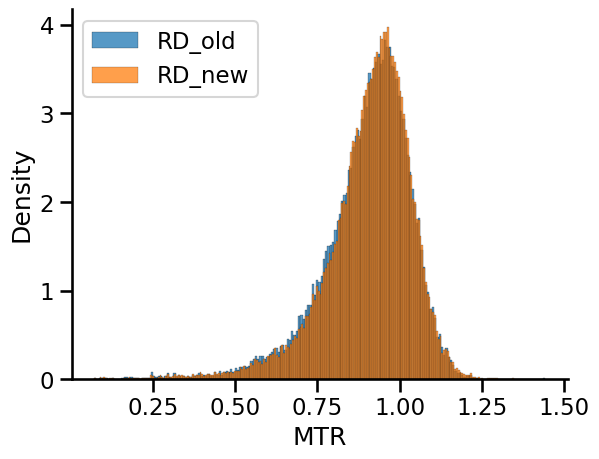

In [225]:
sns.histplot(domain_mtr[domain_mtr[3] == "RD"]["MTR"], label = "RD_old", stat = "density")
sns.histplot(RD_with_mtr_activator_TFs["MTR"], label = "RD_new", stat = "density")
plt.legend()
sns.despine()
# Good - both distributions look approx the same

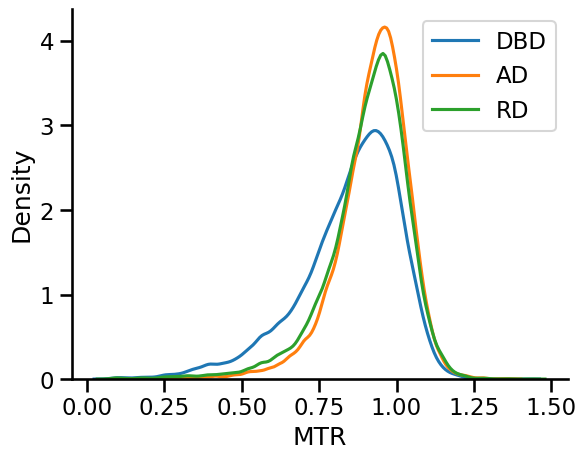

In [226]:
sns.kdeplot(dbd_mtr["MTR"], label = "DBD")
sns.kdeplot(ad_mtr["MTR"], label = "AD")
sns.kdeplot(RD_with_mtr_activator_TFs["MTR"], label = "RD")
plt.legend()
sns.despine()

<Axes: xlabel='percent_disorder', ylabel='Count'>

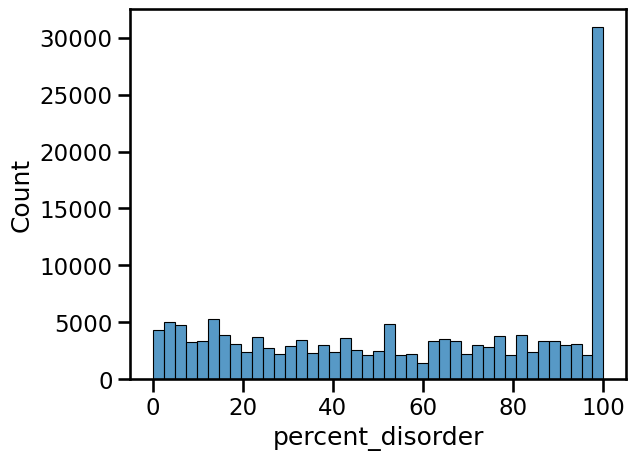

In [237]:
sns.histplot(RD_with_mtr_activator_TFs["percent_disorder"])

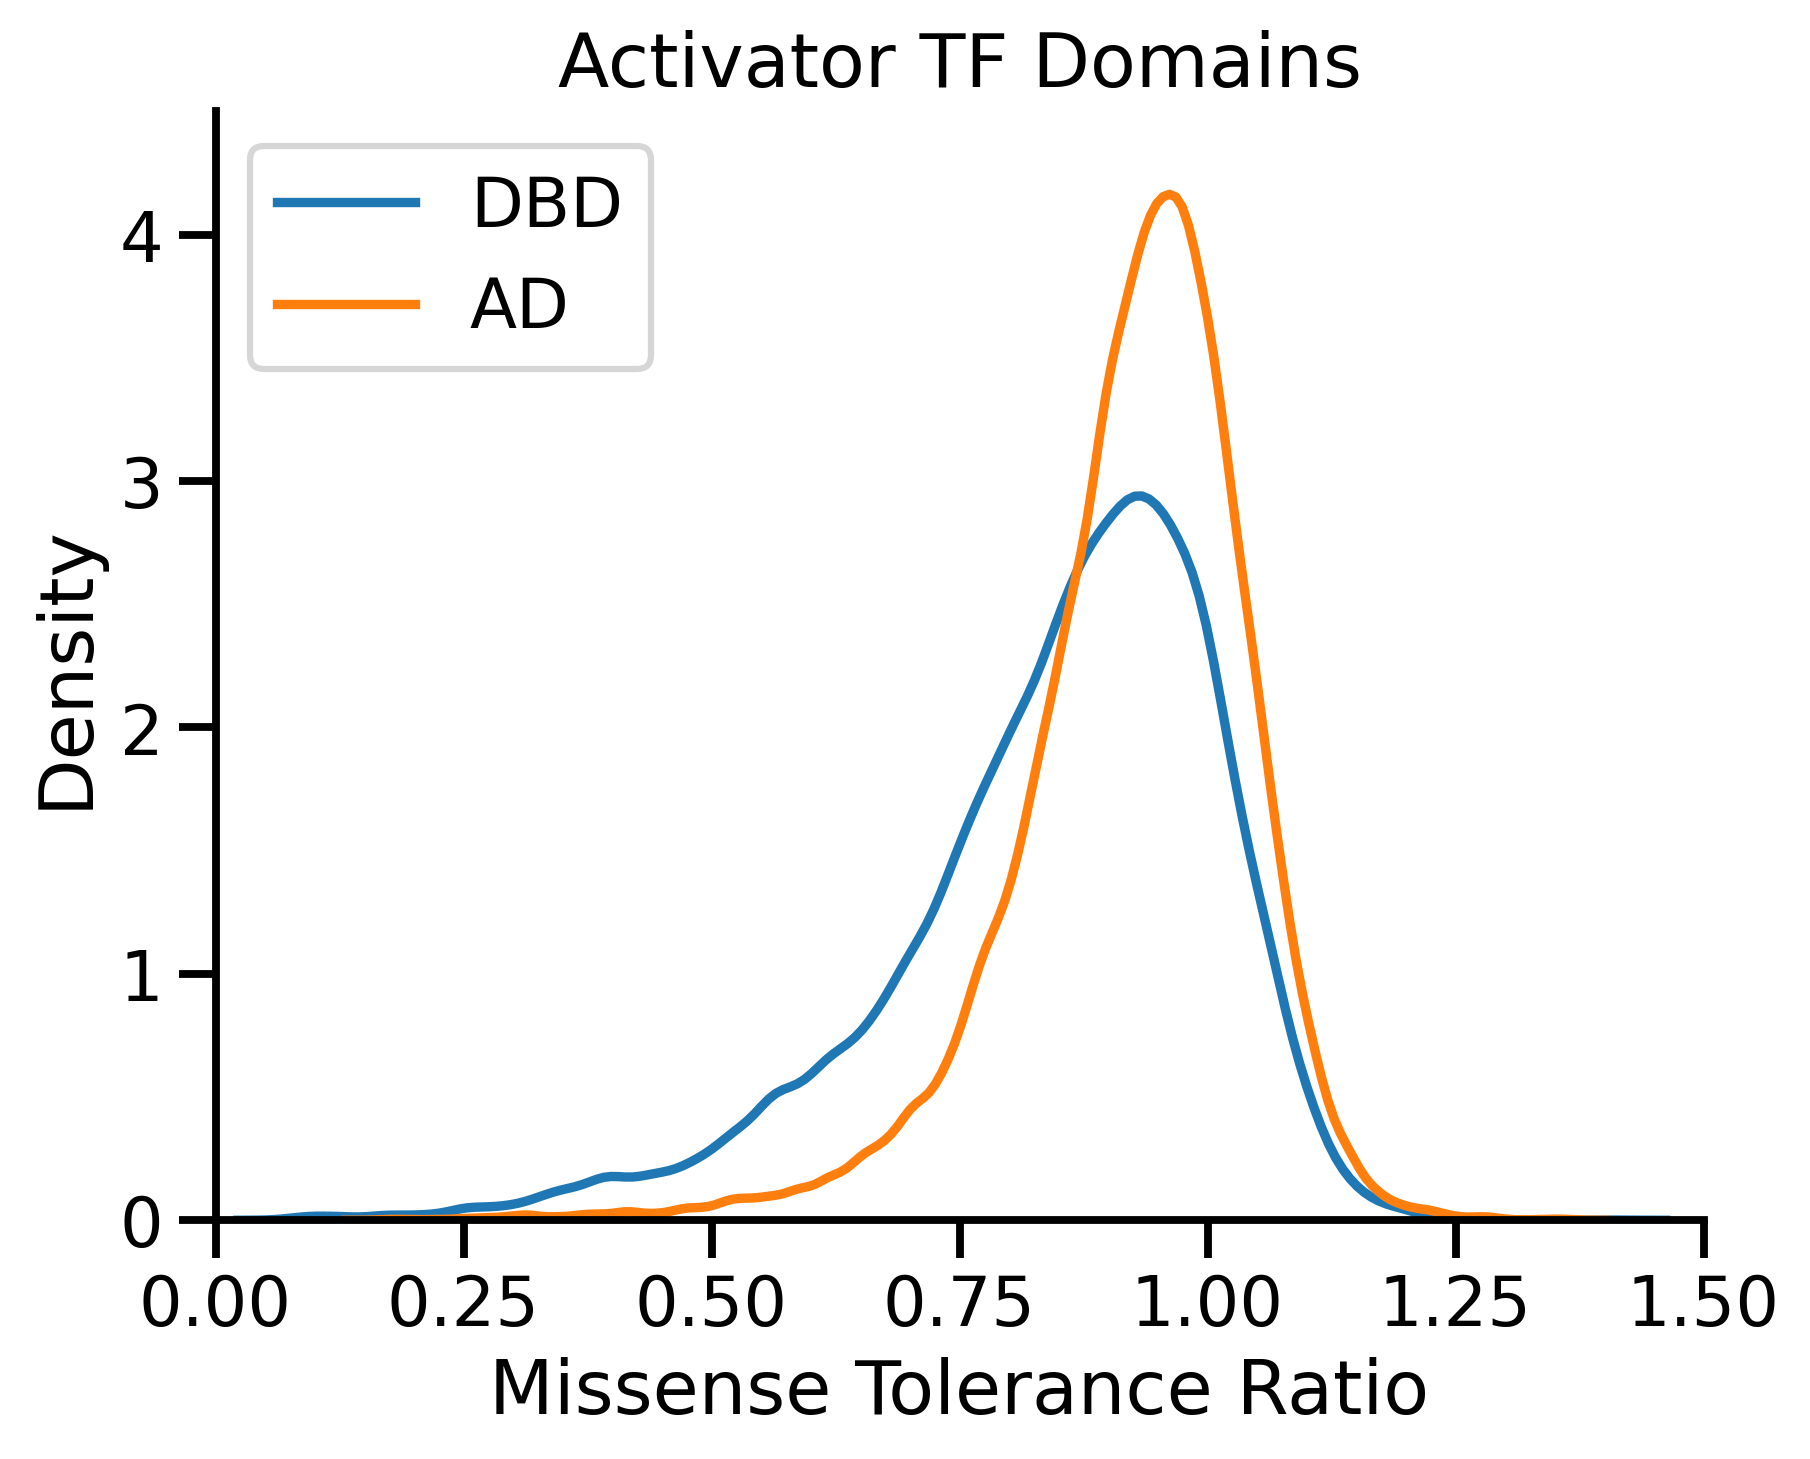

In [252]:
plt.figure(dpi = 300)
plt.title("Activator TF Domains")
plt.xlabel("Missense Tolerance Ratio")

sns.kdeplot(dbd_mtr["MTR"], label = "DBD")
sns.kdeplot(ad_mtr["MTR"], label = "AD")

plt.xlim(0, 1.5)
plt.ylim(0, 4.5)
plt.legend(loc = "upper left")
sns.despine()

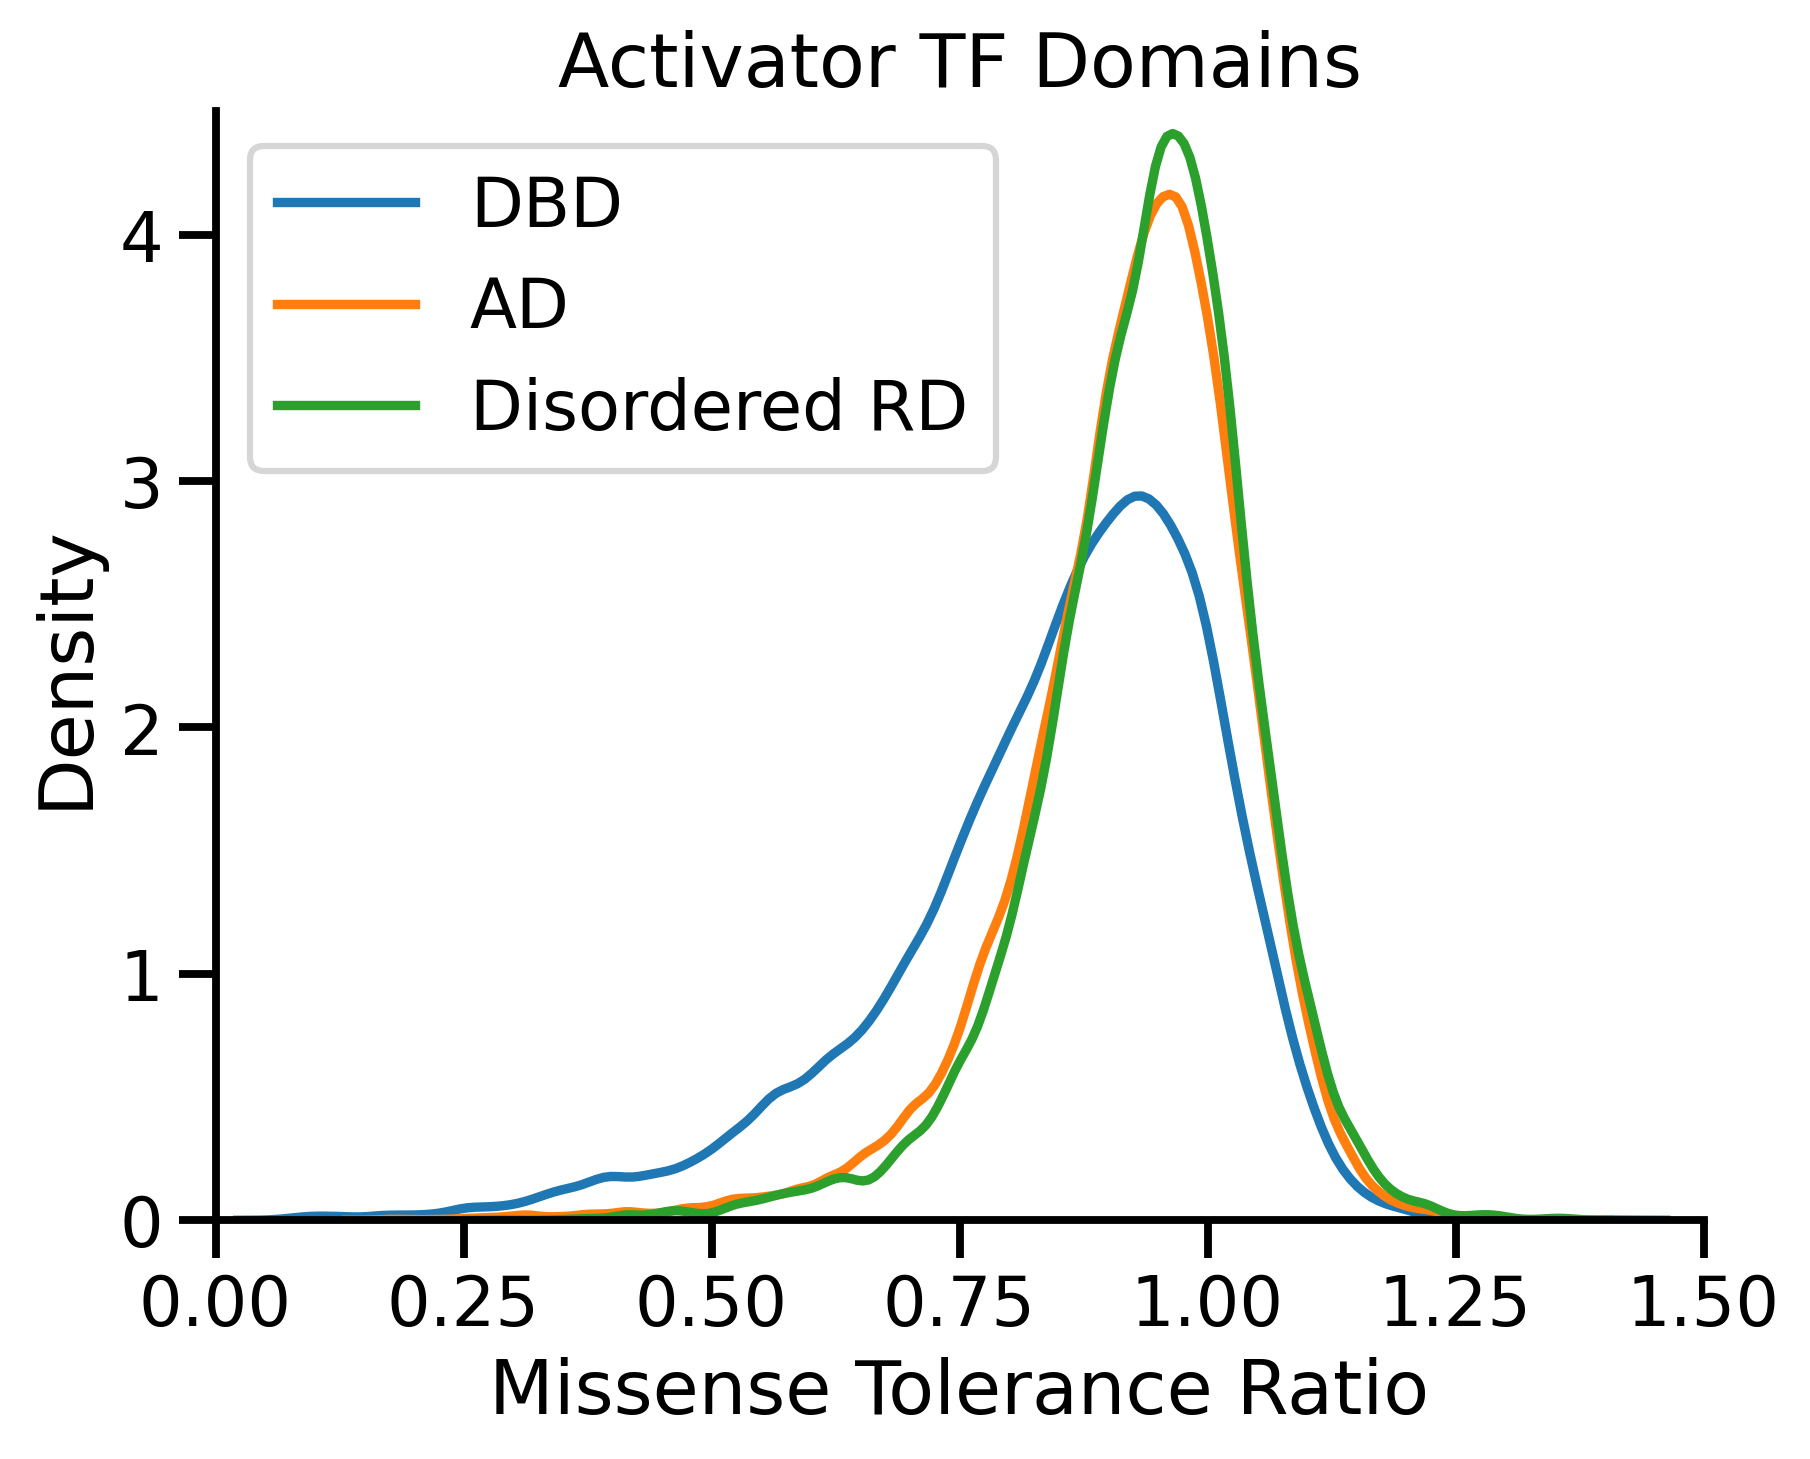

In [251]:
plt.figure(dpi = 300)
plt.title("Activator TF Domains")
plt.xlabel("Missense Tolerance Ratio")

sns.kdeplot(dbd_mtr["MTR"], label = "DBD")
sns.kdeplot(ad_mtr["MTR"], label = "AD")

disordered_RD_with_mtr_activator_TFs = RD_with_mtr_activator_TFs[RD_with_mtr_activator_TFs["percent_disorder"] > 70]
ordered_RD_with_mtr_activator_TFs = RD_with_mtr_activator_TFs[RD_with_mtr_activator_TFs["percent_disorder"] <= 70]

sns.kdeplot(disordered_RD_with_mtr_activator_TFs["MTR"], label = "Disordered RD")


plt.xlim(0, 1.5)
plt.ylim(0, 4.5)
plt.legend(loc = "upper left")
sns.despine()

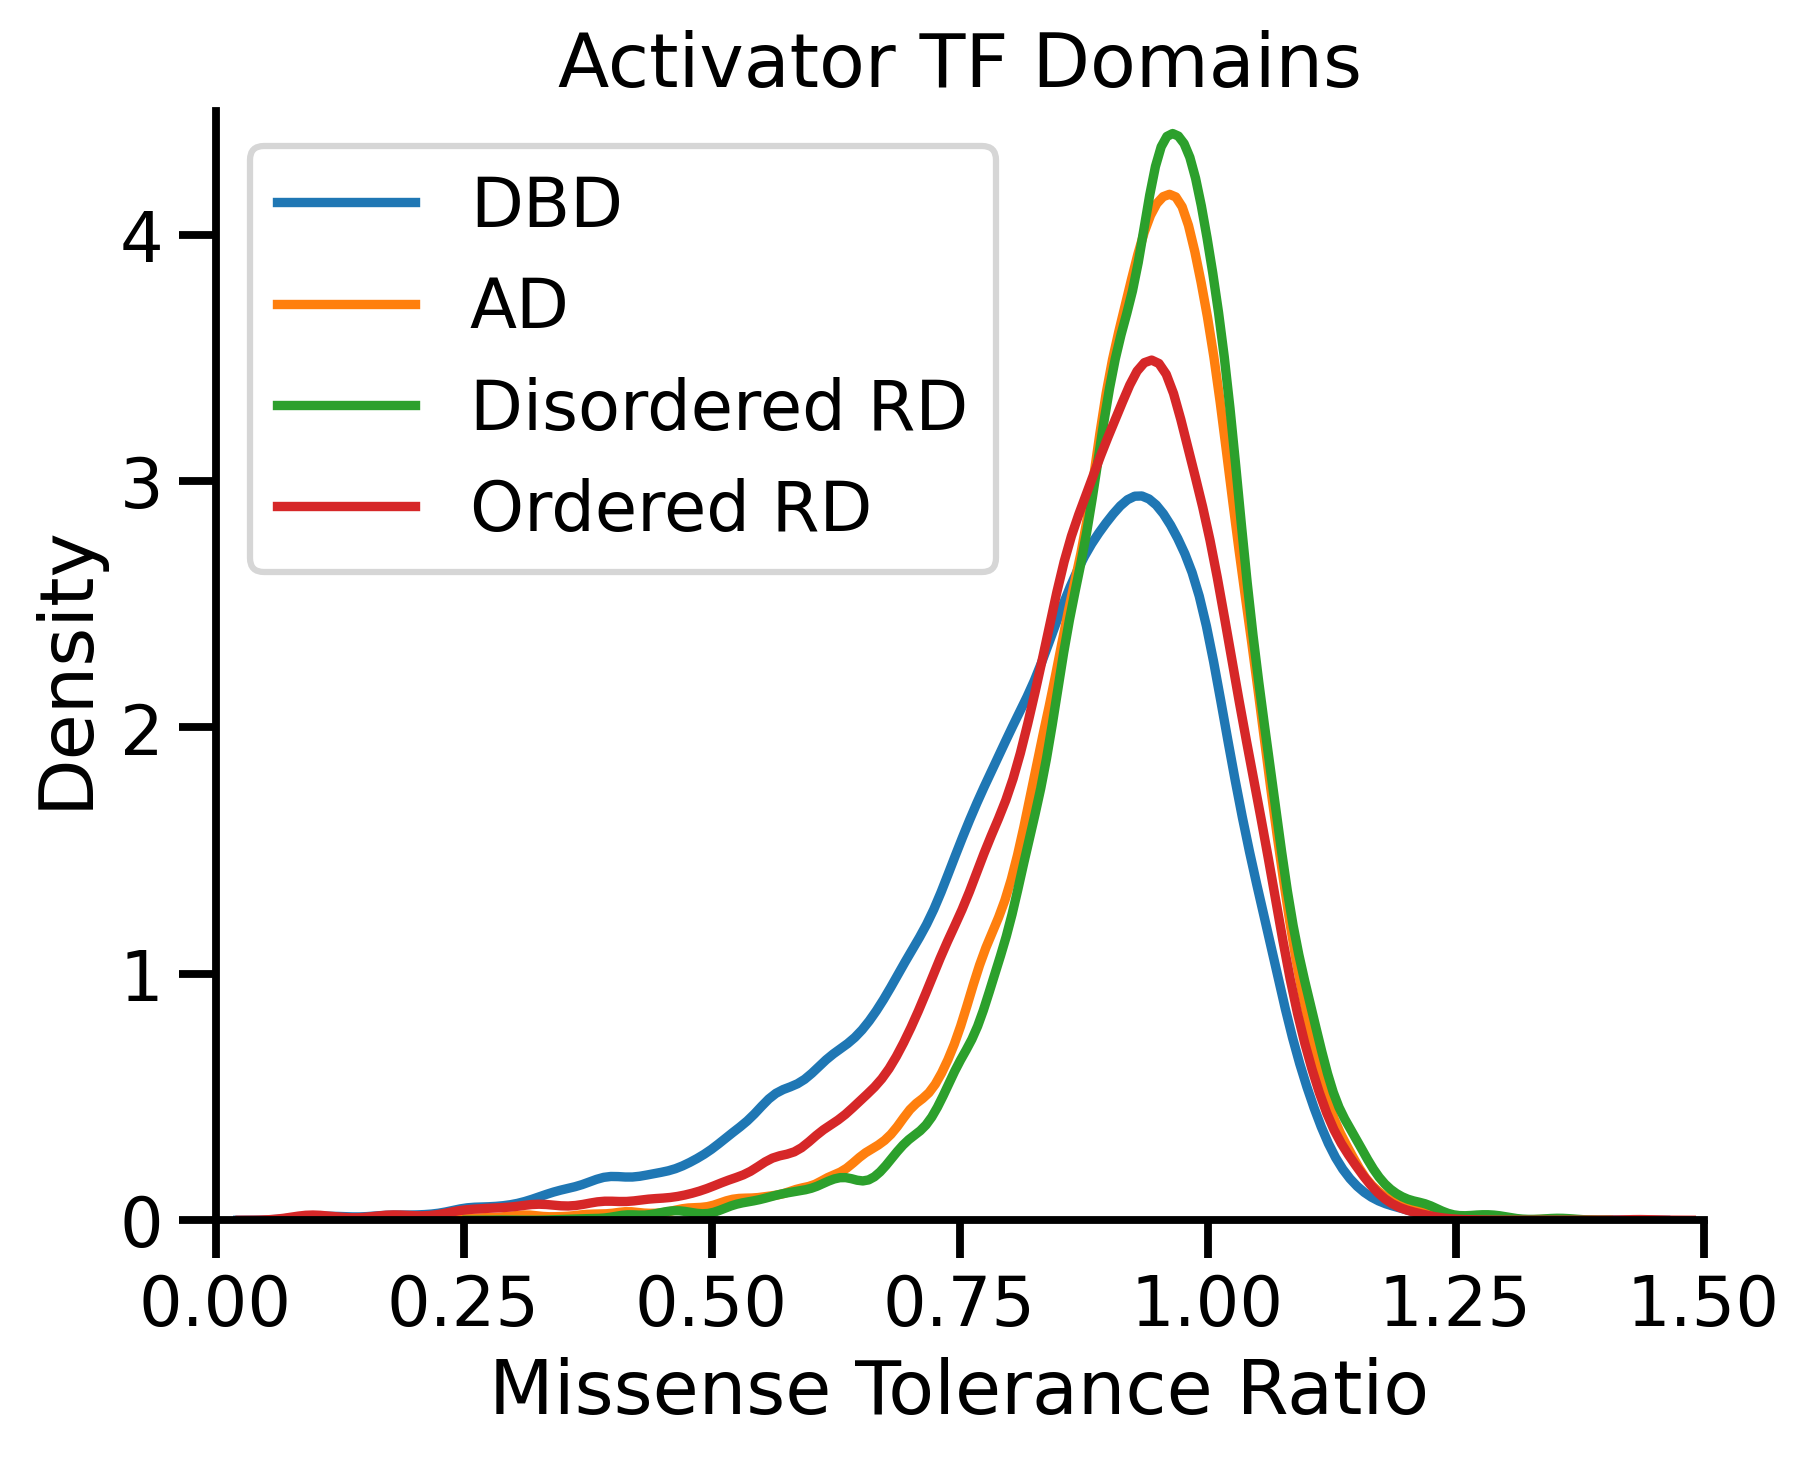

In [250]:
plt.figure(dpi = 300)
plt.title("Activator TF Domains")
plt.xlabel("Missense Tolerance Ratio")

sns.kdeplot(dbd_mtr["MTR"], label = "DBD")
sns.kdeplot(ad_mtr["MTR"], label = "AD")

sns.kdeplot(disordered_RD_with_mtr_activator_TFs["MTR"], label = "Disordered RD")
sns.kdeplot(ordered_RD_with_mtr_activator_TFs["MTR"], label = "Ordered RD")

plt.xlim(0, 1.5)
plt.ylim(0, 4.5)
plt.legend()
sns.despine()

# 3. Within ADs, which residues are under the most constriant?

In [256]:
known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms_and_canonical.csv")
known_ADs= pd.merge(known_ADs, lambert_TF_ENSTs, on = "uniprotID")
known_ADs= known_ADs[["uniprotID", "ENST", "Start", "End"]]
known_ADs

,uniprotID,ENST,Start,End
0,Q8IUX7,ENST00000223357,1088,1158
1,Q8WYP5,ENST00000648844,1445,1698
2,P35869,ENST00000242057,118,126
3,P35869,ENST00000242057,266,268
4,P35869,ENST00000242057,532,848
...,...,...,...,...
592,P17040,ENST00000684572,262,341
593,P98168,ENST00000358697,572,699
594,P98169,ENST00000374888,576,703
595,Q2QGD7,ENST00000389709,579,688


In [260]:
known_ADs_mtr = pd.merge(cds_mtr, known_ADs, on = "ENST")
known_ADs_mtr = known_ADs_mtr[(known_ADs_mtr["Start"] < known_ADs_mtr[10]) & (known_ADs_mtr[10] < known_ADs_mtr["End"])]
known_ADs_mtr

,0,1,2,ENST,4,5,6,7,MTR,9,10,uniprotID,Start,End
7,6,53128211,53128212,ENST00000259803,-1,6,53128211,53128212,1.000560,L,435,Q9NP62,302,436
9,6,53128212,53128213,ENST00000259803,-1,6,53128212,53128213,1.000560,L,435,Q9NP62,302,436
11,6,53128213,53128214,ENST00000259803,-1,6,53128213,53128214,1.000560,L,435,Q9NP62,302,436
13,6,53128215,53128216,ENST00000259803,-1,6,53128215,53128216,1.008164,P,434,Q9NP62,302,436
15,6,53128216,53128217,ENST00000259803,-1,6,53128216,53128217,1.008164,P,434,Q9NP62,302,436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787679,19,15379720,15379721,ENST00000269701,-1,19,15379720,15379721,0.955987,G,4,O43823,2,81
787680,19,15379721,15379722,ENST00000269701,-1,19,15379721,15379722,0.955987,G,4,O43823,2,81
787681,19,15379722,15379723,ENST00000269701,-1,19,15379722,15379723,0.946138,Q,3,O43823,2,81
787682,19,15379723,15379724,ENST00000269701,-1,19,15379723,15379724,0.946138,Q,3,O43823,2,81


In [272]:
known_ADs_mtr[[9, "MTR"]].groupby(9).mean().sort_values(by = "MTR", ascending = True)

,MTR
9,
F,0.910043
I,0.910785
W,0.910830
C,0.912204
K,0.912937
V,0.913857
H,0.915298
L,0.918260
T,0.918503


In [296]:
known_ADs_mtr_order = known_ADs_mtr[[9, "MTR"]].groupby(9).mean().sort_values(by = "MTR", ascending = False).index

In [297]:
known_ADs_mtr['sort_order'] = pd.Categorical(known_ADs_mtr[9], ordered=True, categories=known_ADs_mtr_order)
known_ADs_mtr = known_ADs_mtr.sort_values('sort_order')
known_ADs_mtr

,0,1,2,ENST,4,5,6,7,MTR,9,10,uniprotID,Start,End,sort_order
504174,2,222220315,222220316,ENST00000350526,-1,2,222220315,222220316,0.963866,P,333,P23760,287,479,P
409466,6,1394704,1394705,ENST00000645481,1,6,1394704,1394705,1.040355,P,394,Q12947,191,421,P
409464,6,1394703,1394704,ENST00000645481,1,6,1394703,1394704,1.040355,P,394,Q12947,191,421,P
103699,19,47839854,47839855,ENST00000221996,1,19,47839854,47839855,0.850926,P,263,O43186,192,291,P
103697,19,47839853,47839854,ENST00000221996,1,19,47839853,47839854,0.850926,P,263,O43186,192,291,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216251,8,70155987,70155988,ENST00000452400,-1,8,70155987,70155988,0.955323,F,793,Q15596,786,825,F
216248,8,70155986,70155987,ENST00000452400,-1,8,70155986,70155987,0.955323,F,793,Q15596,786,825,F
216245,8,70155985,70155986,ENST00000452400,-1,8,70155985,70155986,0.955323,F,793,Q15596,786,825,F
4498,6,152094397,152094398,ENST00000443427,1,6,152094397,152094398,0.723977,F,461,P03372,282,595,F


In [298]:
# All plotting controls

amino_acid_colors_white = {
    # Purples
    'F': '#306BAC',  
    'W': '#306BAC',
    'L': '#306BAC',
    'Y': '#306BAC',
    
    # Reds
    'D': '#D04741', 
    'E': '#D04741', 

    # Blues
    'K': '#52B0E1', 
    'R': '#52B0E1', 

    # black
    'S': '#000000', 
    'P': '#000000',

    # greys
    'A': '#787878',
    'V': '#787878',
    'I': '#787878',
    'M': '#787878',
    'T': '#787878',
    'G': '#787878',
    'C': '#787878',
    'N': '#787878',
    'Q': '#787878',
    'H': '#787878',  
     
    '-': "#FFFFFF", 
    "X": "#787878"
}


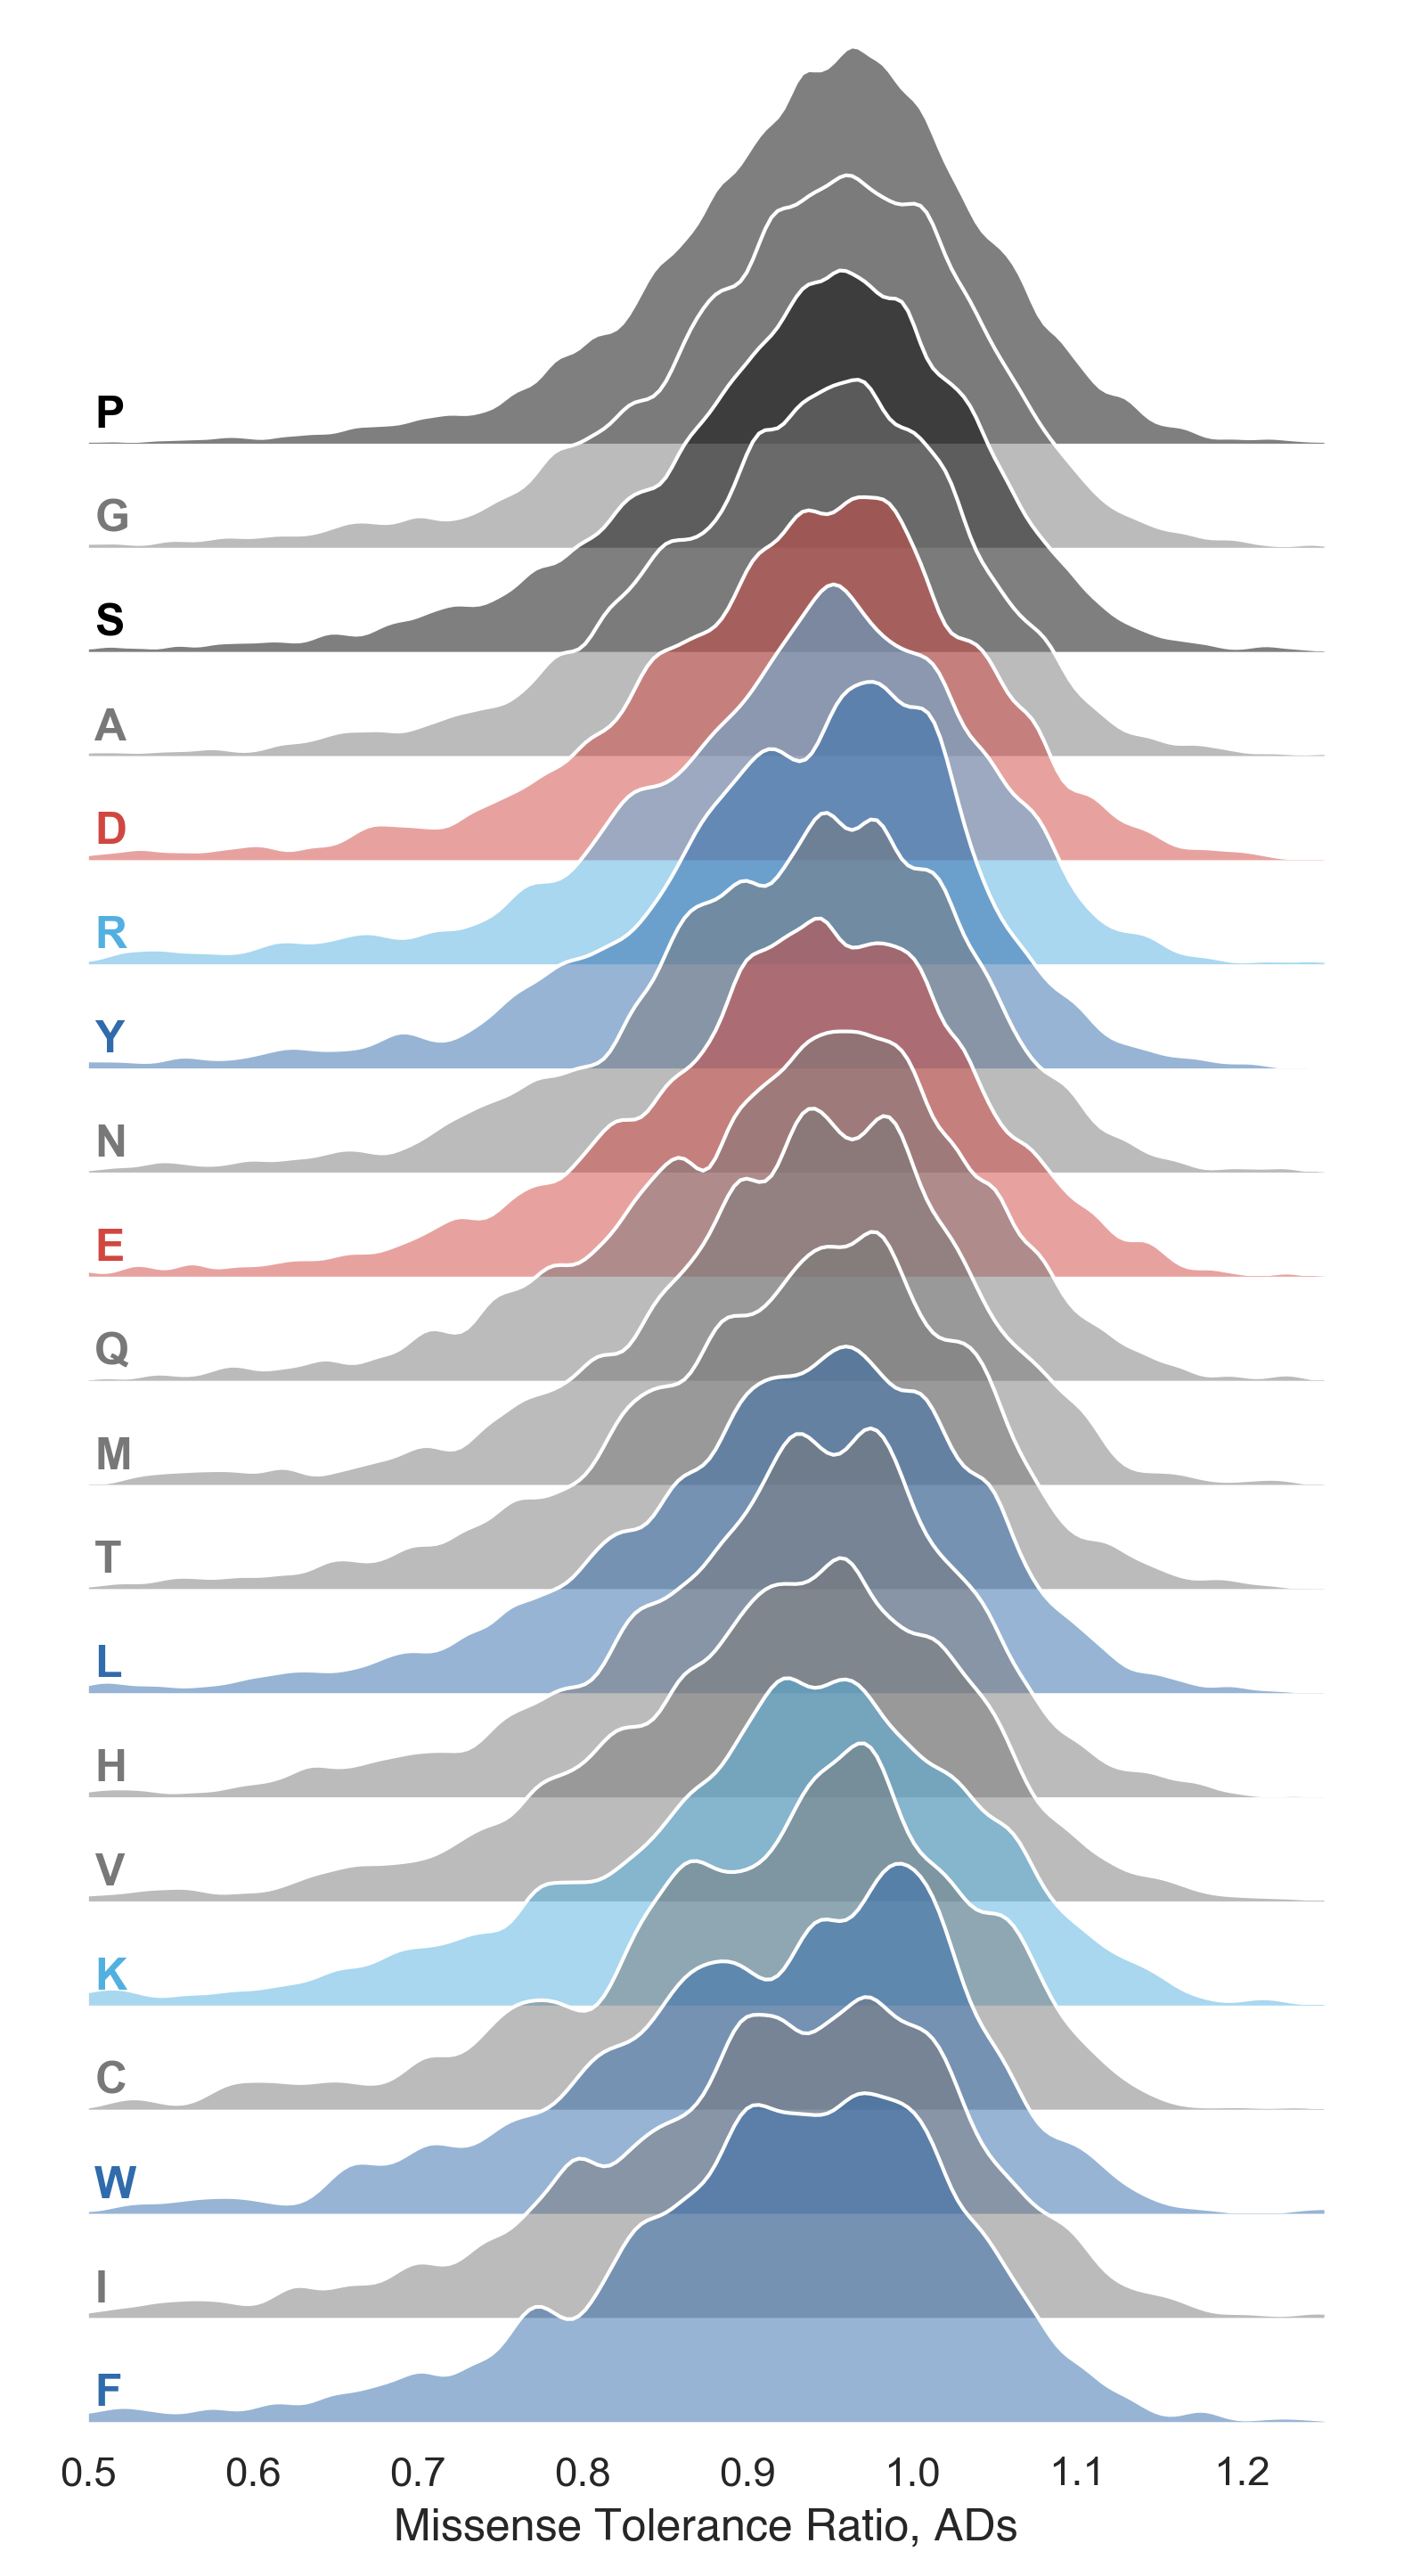

In [304]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.rcParams['figure.dpi'] = 300


g = sns.FacetGrid(known_ADs_mtr, row=9, hue=9, aspect=12, height=0.5, palette = amino_acid_colors_white)

# Draw the densities in a few steps
g.map(sns.kdeplot, "MTR",
      bw_adjust=.5, clip = (0.5,1.25),
      fill=True, alpha=0.5, linewidth=0)
g.map(sns.kdeplot, "MTR", clip = (0.5,1.25), color="w", lw=1, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.05, 0.065, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "MTR")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.75)

for ax in g.axes.flat[-g.axes.shape[1]:]:  # Bottom row (last `g.axes.shape[1]` axes)
    ax.set_xlabel("Missense Tolerance Ratio, ADs", font = "Helvetica")  # Set x-axis label for the bottom row

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)